In [1]:
import pandas as pd
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR as api_var
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

In [2]:
class AutoVAR():
    
    '''
    Vector Autoregression model

    Attributes
    ----------
    self.data_backup: dataframe, a backup copy of the input dataset
    self.data: dataframe, the main dataset worked on
    self.n: int, length (unit in months) of target to predict
    self.df_result: dataframe, stores the predicted target and the true target
    self.lag: int, number of past months used to predict the target
    self.column_name: list of str, names of columns used to predict the target
    self.rmse: rounded RMSE of the prediction
    self.target: str, name of target variable
    
    Params
    ----------
    data_name: str, name of the dataset. Notice the input dataset must contain a column named 'Date.'
    target_name: str, name of target variable
    drop_cols: list of strings, names of columns to drop
    '''
    def __init__(self, data_name, target_name, drop_cols=['Date']):   
        #import data
        curr_path = os.getcwd()
        input_path = os.path.join(curr_path, data_name)
        data = pd.read_excel(input_path, engine='openpyxl',)
        
        #drop columns and na
        drop_cols.remove('Date')
        data.drop(drop_cols, axis=1, inplace=True)
        data.dropna(inplace = True)
        data.reset_index(drop=True, inplace=True)
        
        #set attributes
        self.data_backup = data.copy(deep=False)
        self.data = data.drop(['Date'], axis=1)
        
        self.n = 0
        self.df_result = 0
        self.lag = 0
        self.column_name = []
        self.rmse = 0
        self.target = target_name

        
    def print_date_range(self):
        #Print Range of Date column
        print('Date Range: ', self.data_backup['Date'].iloc[0], '--', self.data_backup['Date'].iloc[-1])
        
    def grangers_causation_matrix(self, data, variables, maxlag, test='ssr_chi2test', verbose=False):
        '''Calculate Granger causation matrix. Function borrowed from 
        https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with
        
        Parameters
        ----------
        data: dataframe, dataframe to calculate causation matrix on
        variable: list of str, column names of data
        maxlag: int, number of past months used to predict the target
        
        Returns
        -------
        df: Granger causation matrix
        '''
        df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for c in df.columns:
            for r in df.index:
                test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                df.loc[r, c] = min_p_value
        df.columns = [var + '_x' for var in variables]
        df.index = [var + '_y' for var in variables]
        return df
    
    def run(self, pred_begin_date, n, maxlag=12, if_gc=False):
        '''run VAR, apply stationary test and choose lag order by AIC test
        
        Parameters
        ----------
        pred_begin_date: date, the begin date of prediction
        n: int, length (unit in months) of prediction
        maxlag: max lag order allowed
        if_gc: boolean, whether using granger causality test for filtering predictors
        
        '''
            
        #set attributes
        self.n = n
        test_date_begin = self.data_backup.index[self.data_backup['Date'] == pred_begin_date].tolist()[0]
        df_train, df_test = self.data.iloc[:test_date_begin], self.data.iloc[test_date_begin:test_date_begin+n]
        
        # apply difference method to df_train
        df_train_trans = df_train.diff().dropna()
        
        #drop columns still unstable after differencing
        for col in df_train_trans.columns:
            result = adfuller(df_train_trans[col].values)
            if result[1] > 0.05:
                df_train_trans.drop([col], axis=1, inplace=True)
                print('for stationary, dropped: ', col)

        # Use AIC to find Lag Order and then fit model
        model = api_var(df_train_trans.values)
        AIC_lst = []
        for i in range(1, maxlag):
            result = model.fit(i)
            AIC_lst.append(result.aic)
        lags = np.argmin(AIC_lst) + 1
        results = model.fit(maxlags=lags, ic='aic')
        
        if if_gc:
            #drop unnecessary columns based on granger_causation
            gc_mat = self.grangers_causation_matrix(df_train_trans, variables = df_train_trans.columns, maxlag = lags)
            target_idx = gc_mat.columns.get_loc(self.target + '_x')
            col_idx = (gc_mat.iloc[[target_idx]]>0.05).values[0]
            dropped_col_names = gc_mat.columns.values[col_idx].tolist()
            dropped_col_names.remove(self.target + '_x')
            dropped_col_names = [i[:-2] for i in dropped_col_names]
            
            print('by granger causation matrix, dropped: ', dropped_col_names, '\n')
            
            #Refit and Predict
            df_train_trans = df_train_trans.drop(dropped_col_names, axis=1)
            model = api_var(df_train_trans.values)
            AIC_lst = []
            for i in range(1, maxlag):
                result = model.fit(i)
                AIC_lst.append(result.aic)
            lags = np.argmin(AIC_lst) + 1

        results = model.fit(maxlags=lags, ic='aic')
        
        self.lag = lags
        
        df_test_trans = self.data.diff().dropna()[-n:].reindex()
        data_pred = results.forecast(y=df_train_trans.values[-lags:], steps=n)
        df_forecast = (pd.DataFrame(data_pred, index=df_test.index, columns=df_train_trans.columns + '_pred'))
        self.column_name = df_train_trans.columns.values
        
        df_forecast.reset_index(drop=True, inplace=True)
        df_test_trans.reset_index(drop=True, inplace=True)
        df_result = pd.concat([df_forecast[self.target + '_pred'], df_test_trans[self.target].dropna()], axis=1)

        #detransformation and calculate RMSE
        df_result[self.target + '_pred'] = df_train[self.target].iloc[-1] + df_result[self.target + '_pred'].cumsum()
        df_result[self.target] = df_train[self.target].iloc[-1] + df_result[self.target].cumsum()
        df_result['Date'] = self.data_backup['Date'][test_date_begin:test_date_begin+self.n].values
        df_result.set_index(['Date'],inplace=True)
        self.df_result = df_result
        rmse2 = mean_squared_error(df_result[self.target + '_pred'], df_result[self.target], squared=False)
        self.rmse = rmse2
        print('RMSE: ', round(rmse2,2))

In [3]:
var_model = AutoVAR(data_name='merged_data_1020.xlsx', target_name='SP500-EPS-Index', drop_cols=['Date','SP500-Price','gdp','ManufacturingNewOrders','ConstructionSpending'])
var_model.print_date_range()

Date Range:  1979-02-01 00:00:00 -- 2019-10-01 00:00:00


for stationary, dropped:  M2
RMSE:  100.89
model predictors:  ['SP500-EPS-Index' 'IndustrialProduction' 'GS10' 'CPIFABSL'
 'MedianUsualWeeklyRealEarnings' 'PCE' 'PPI'
 'VolumeOfTotalRetailTradeSales-GR' 'HousingSales' 'UnemploymentRate'
 'EffectiveRate' 'GovernmentBudgetBalance'] 


for stationary, dropped:  M2
by granger causation matrix, dropped:  ['GS10', 'UnemploymentRate', 'EffectiveRate'] 

RMSE:  46.84
model predictors: ['SP500-EPS-Index' 'IndustrialProduction' 'CPIFABSL'
 'MedianUsualWeeklyRealEarnings' 'PCE' 'PPI'
 'VolumeOfTotalRetailTradeSales-GR' 'HousingSales'
 'GovernmentBudgetBalance'] 




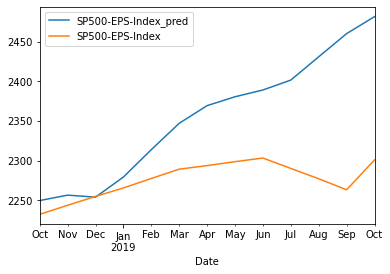

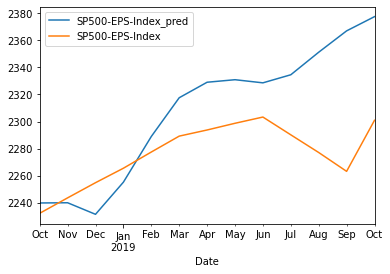

In [4]:
d = '2018-10-01 00:00:00'
n = 13
l = 15

var_model.run(pred_begin_date=d, n=n, maxlag=l, if_gc=False)
var_model.df_result.plot()
print('model predictors: ', var_model.column_name, '\n\n')

var_model.run(pred_begin_date=d, n=n, maxlag=l, if_gc=True)
var_model.df_result.plot()
print('model predictors:', var_model.column_name, '\n\n')